In [1]:
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd

from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.scheduler.model_observatory import ModelObservatory
from rubin_scheduler.scheduler.surveys import PointingsSurvey
from rubin_scheduler.scheduler.utils import empty_observation
from rubin_scheduler.scheduler.schedulers import CoreScheduler

from astropy import units
from astropy.coordinates import Angle

import pickle

In [2]:
# Read in a list of pointings we might want to observe
tiles = pd.read_csv('auxtel_tiles.txt', delimiter=' ')
tiles

,Survey,Name,RA,Dec
0,LATISS_POLE,001,00:00:00.00,-89:53:48.23
1,LATISS_POLE,002,02:10:54.54,-89:53:48.23
2,LATISS_POLE,003,04:21:49.09,-89:53:48.23
3,LATISS_POLE,004,06:32:43.63,-89:53:48.23
4,LATISS_POLE,005,08:43:38.18,-89:53:48.23
...,...,...,...,...
794,AUXTEL_PHOTO_IMAGING,Photo1800-1_028,18:00:46.04,-24:57:20.25
795,AUXTEL_PHOTO_IMAGING,Photo1800-1_029,18:00:49.96,-24:57:20.25
796,AUXTEL_PHOTO_IMAGING,Photo1800-1_030,18:00:53.88,-24:57:20.25
797,AUXTEL_PHOTO_IMAGING,Photo1800-1_031,18:00:57.79,-24:57:20.25


In [3]:
# Convert these to an observation array
obs = empty_observation(n=len(tiles))
obs['note'] = tiles['Survey'] + tiles['Name']
obs['RA'] = Angle(tiles['RA'],unit=units.hourangle).rad
obs['dec'] = Angle(tiles['Dec'],unit=units.degree).rad

obs['flush_by_mjd'] = 0.
obs['nexp'] = 1
obs['filter'] = 'r'
obs['exptime'] = 60.

In [4]:
# load the potential observations into a PointingsSurvey
# by default, the PointingsSurvey will stick on a detailer that 
# sets each observation to the parallactic angle. For now we'll clobber 
# that so all the observations get taken with rotTelPos=0
ps = PointingsSurvey(obs, detailers=[])
sched = CoreScheduler([ps])


In [5]:
# Try observing with the survey for 3 days
mo = ModelObservatory()
mo, sched, completed_obs = sim_runner(mo, sched, survey_length=3)


/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:203: RuntimeWarning: divide by zero encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:203: RuntimeWarning: invalid value encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)


progress = 65.27%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:280: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 100.00%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 1886 observations
ran in 0 min = 0.0 hours


Text(0.5, 1.0, 'Completed observations')

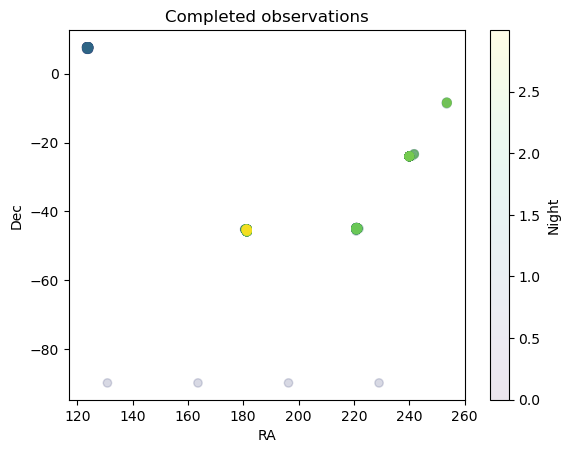

In [6]:
fig, ax = plt.subplots()
ack = ax.scatter(np.degrees(completed_obs['RA']), np.degrees(completed_obs['dec']),
            c=completed_obs['mjd']-completed_obs['mjd'].min(), alpha=0.1)
cb = plt.colorbar(ack)
cb.set_label('Night')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title('Completed observations')

In [7]:
# What does the scheduler look like
sched

CoreScheduler(
            surveys=[[<PointingsSurvey at 0x17a65ec90>]],
            camera="LSST",
            nside=32,
            rotator_limits=array([1.48352986, 4.79965544]),
            survey_index=[0, 0],
            log=<Logger CoreScheduler (WARNING)>
        )

In [8]:
conditions = mo.return_conditions()

In [9]:
# output a pretty table showing the current status of the survey
sched.survey_lists[0][0].make_reward_df(conditions)

,method,blank,feasible,max_reward,n_possibles,weight,max_accum_reward,accum_n
0,visit_gap,None,True,0.000000,776,1.0,0.000000,776
1,balance_revisit,None,True,1.000000,799,1.0,1.000000,776
2,m5diff,None,True,-0.138573,313,1.0,0.861427,290
3,slew_time,None,True,-3.843154,313,-1.0,-3.068573,290
4,wind_limit,None,True,0.000000,799,0.0,-3.068573,290
5,ha_limit,None,True,0.000000,132,0.0,-3.068573,109
6,alt_limit,None,True,0.000000,313,0.0,-3.068573,109
7,moon_limit,None,True,0.000000,735,0.0,-3.068573,45


Text(0, 0.5, 'Dec')

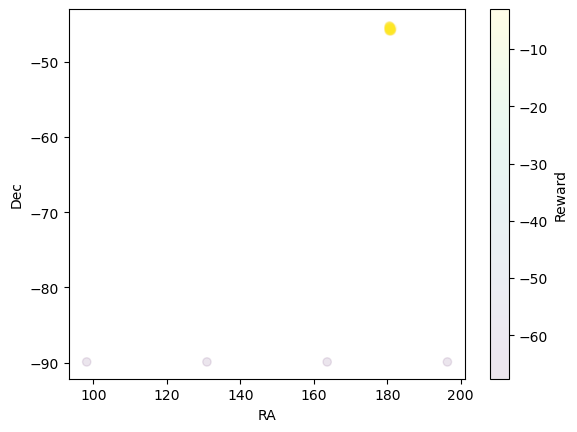

In [10]:
# can look at the reward for each potential observations on the sky
fig, ax = plt.subplots()
ack = ax.scatter(np.degrees(sched.survey_lists[0][0].observations['RA']),
            np.degrees(sched.survey_lists[0][0].observations['dec']),
            c=sched.survey_lists[0][0].reward, alpha=0.1)
cb = plt.colorbar(ack)
cb.set_label('Reward')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

In [11]:
# How big is it to dump this scheduler
file = open('save_test.pkl', 'wb')
pickle.dump(sched, file)
file.close()
from subprocess import Popen
Popen('ls -lh *.pkl', shell=True)

<Popen: returncode: None args: 'ls -lh *.pkl'>

Pros and cons

Cons:

* Not as modular as using basis function objects
* Setting an altitude limit of observations taken by a `PointingSurvey` object is done differently than in a `BlobSurvey`. (but we have the same issue with `ScriptedSurveys` where the logic on when to execute doesn't use only basis functions.)

Pros

* Scalable. 1 to 1,000,000 potential pointings, no problem. No looping over many survey objects.
* Small memory/storage footprint. 3M uncompressed, <1M compressed. Current Auxtel uncompressed is 157M
* Easy to output debugging data frame analagous to the other surveys
* Easier to configure since all the logic is already in the class. One-liner to make the survey class